In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [62]:
drive_window_region = np.array([500.0 / 1920, 280.0 / 1080, 1100.0 / 1920, 360.0 / 1080])


def GetRectFromRegion(region: np.array, width, height):
    x = float(width) * region[0]
    y = float(height) * region[1]
    region_width = float(width) * region[2]
    region_height = float(height) * region[3]
    return np.array([x, y, region_width, region_height], dtype=np.int)

rect = GetRectFromRegion(drive_window_region, 1920, 1080)

In [63]:
def canny_edge_detector(image): 
      
    # Convert the image color to grayscale 
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
      
    # Reduce noise from the image 
    blur = cv2.GaussianBlur(gray_image, (5, 5), 0)  
    canny = cv2.Canny(blur, 50, 150) 
    return canny 

In [64]:
def region_of_interest(image): 
    height = image.shape[0] 
    polygons = np.array([ 
        [(100, height), (1100, height), (350, 150)] 
        ]) 
    mask = np.zeros_like(image) 
      
    # Fill poly-function deals with multiple polygon 
    cv2.fillPoly(mask, polygons, 255)  
      
    # Bitwise operation between canny image and mask image 
    masked_image = cv2.bitwise_and(image, mask)  
    return masked_image 

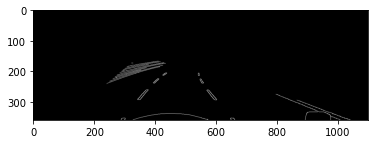

In [65]:
img = cv2.imread('../images/1591496878759.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
edge_window = canny_edge_detector(drive_window_img)
roi_edge = region_of_interest(edge_window)
plt.imshow(roi_edge, cmap='gray')

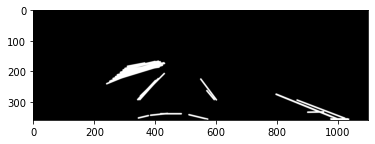

In [66]:
cdstP = np.zeros_like(roi_edge)
lines = cv2.HoughLinesP(roi_edge, 2, np.pi / 180, 50, minLineLength = 10, maxLineGap = 50)
if lines is not None:
    for i in range(len(lines)):
        l = lines[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255), 3, cv2.LINE_AA)
plt.imshow(cdstP, cmap='gray')

In [7]:
def average_slope_intercept(image, lines): 
    left_fit = [] 
    right_fit = [] 
    for line in lines: 
        x1, y1, x2, y2 = line.reshape(4) 
          
        # It will fit the polynomial and the intercept and slope 
        parameters = np.polyfit((x1, x2), (y1, y2), 1)  
        slope = parameters[0] 
        intercept = parameters[1] 
        if slope < 0: 
            left_fit.append((slope, intercept)) 
        else: 
            right_fit.append((slope, intercept)) 
              
    left_fit_average = np.average(left_fit, axis = 0) 
    right_fit_average = np.average(right_fit, axis = 0) 
    left_line = create_coordinates(image, left_fit_average) 
    right_line = create_coordinates(image, right_fit_average) 
    return np.array([left_line, right_line]) 

In [8]:
def display_lines(image, lines): 
    line_image = np.zeros_like(image) 
    if lines is not None: 
        for x1, y1, x2, y2 in lines: 
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10) 
    return line_image 

In [9]:
def create_coordinates(image, line_parameters): 
    slope, intercept = line_parameters 
    y1 = image.shape[0] 
    y2 = int(y1 * (3 / 5)) 
    x1 = int((y1 - intercept) / slope) 
    x2 = int((y2 - intercept) / slope) 
    return np.array([x1, y1, x2, y2]) 

In [10]:
frame = drive_window_img.copy()
lines = cv2.HoughLinesP(roi_edge, 2, np.pi / 180, 100,  
                            np.array([]), minLineLength = 40,  
                            maxLineGap = 5)
averaged_lines = average_slope_intercept(frame, lines)  
line_image = display_lines(frame, averaged_lines) 
combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)  
cv2.imshow("results", combo_image) 

C:\Users\DHH\miniconda3\envs\ets2\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\DHH\miniconda3\envs\ets2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: cannot unpack non-iterable numpy.float64 object